In [1]:
import requests as r
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [ ]:
from dotenv import load_dotenv
from os import environ
load_dotenv()

In [26]:
base = "https://api.github.com"
username = environ['user']
token = environ['token']

In [27]:
def flatten(t):
    return [item for sublist in t for item in sublist]

hyperparams = {'train_files','dev_files', 'test_files', 'train_batch_size', 'dev_batch_size', 'test_batch_size', 'n_hidden', 'learning_rate','dropout_rate', 'epochs', 'lm_alpha','lm_beta'}
imp_hyperparams = {'train_batch_size', 'dev_batch_size', 'test_batch_size', 'n_hidden', 'learning_rate','dropout_rate', 'epochs', 'lm_alpha','lm_beta'}

def tup_dict(raw: list, filter: set) -> dict:
    return {key:value for key,value in raw if key in filter}

In [96]:
class Github(object):
    def __init__(self, username, token,base=base):
        '''
        Binds necessary variables for requests.
        '''
        self.base = base 
        self.user = username 
        self.token = token
    def __parse_params(self, param_dict: dict) -> str:
        '''
        Turns a dictionary of requests into API parameters.
        e.g {"page":2, "per_page":100} -> "page=2&per_page=100"
        ''' 
        return "&".join(f'{key}={pair}' for key, pair in param_dict.items())

    def __get_page(self, link: str, param_dict: dict):
        '''
        Returns a page using the API. Typically:
        https://api.github.com/...
        :param link: String for the link to request.
        :param param_dict: Additional parameters to request, such as the page and number of items.
        '''        
        #return f'{base}/{link}?{self.__parse_params(param_dict)}'        
        
        return r.get(f'{base}/{link}?{self.__parse_params(param_dict)}',
         auth =  (self.user,self.token))
    
    
    def get_repo(self, repo: str, subpage: str = '', param_dict: dict = {}):
        '''
        Retrieves repository information as a dictionary.
        :param repo: Repository name of format Author/Repository
        :param subpage: A subpage, such as the releases, commits and so on. (Optional)
        '''
        return self.__get_page(f'repos/{repo}/{subpage}', param_dict)
    
    def repo_search(self, keyword: str, param_dict: dict = {}):
        return self.__get_page(f'search/repositories', {'q':keyword} | param_dict)


    def get_releases(self, repo: str, param_dict: dict = {}):
        '''
        Gets up to 30 releases (?) for a repository, if available.

        '''
        return self.get_repo(repo, 'releases', param_dict)

    def get_commits(self, repo: str, param_dict: dict = {}):
        '''
        Gets up to 30 commits for a repository.
        ''' 
        return self.get_repo(repo, 'commits', param_dict)

    def retrieve(self, link: str):
        return self.__get_page(link,{})



### Preliminary Notes 

Github pagination bottlenecks at 100 per page. Ensure separate pages are selected to scrape all information.


## Releases

When scraping a release page, there are the following keys:
['url', 'assets_url', 'upload_url', 'html_url', 'id', 'author', 'node_id', 'tag_name', 'target_commitish', 'name', 'draft', 'prerelease', 'created_at', 'published_at', 'assets', 'tarball_url', 'zipball_url', 'body', 'reactions']
URL - The URL to the page.
Assets/Upload URL - Same as each other and similar to the above.
HTML URL - The human friendly  url.
Tag Name - Version of the release.
Prerelease - Differentiates between official and prerelease.
Target Commitish - Always Master from observation.
Created At/ Published At - Better to use published at.
Body - Will likely be empty for prereleases, but contains the main chunk we're interested in.
Assets - URL+ Info on any attachments

The rest are largely unimportant for the project or optional, meaning they may not exist (reactions).

The things of interest are:
URL, Tag Name, Prerelease, Creation/Publish Date, Body.

## Commits

When scraping a commits the following keys are:
['sha', 'node_id', 'commit', 'url', 'html_url', 'comments_url', 'author', 'committer', 'parents']

Look to commit:
['author', 'committer', 'message', 'tree', 'url', 'comment_count', 'verification']

Author, may be important, message, comment count (replies).

Want:
commit -> author -> date, name (?)
message

### Hyperparameters to record

The primary hyperparameters are:
- train_files
- dev_files
- test_files
- train_batch_size 
- dev_batch_size
- test_batch_size
- epoch
- learning rate
- dropout_rate
- default_stddev
- checkpoint_step
- n_hidden


In [73]:
yes = r.get('https://api.github.com/search/repositories?q=Deep-Learning').json()

In [102]:
nlp_sample = g.repo_search('neural-networks',param_dict={'per_page':100})

In [103]:
nlp_sample.json()

{'total_count': 111321,
 'incomplete_results': False,
 'items': [{'id': 18666758,
   'node_id': 'MDEwOlJlcG9zaXRvcnkxODY2Njc1OA==',
   'name': 'darknet',
   'full_name': 'pjreddie/darknet',
   'private': False,
   'owner': {'login': 'pjreddie',
    'id': 302108,
    'node_id': 'MDQ6VXNlcjMwMjEwOA==',
    'avatar_url': 'https://avatars.githubusercontent.com/u/302108?v=4',
    'gravatar_id': '',
    'url': 'https://api.github.com/users/pjreddie',
    'html_url': 'https://github.com/pjreddie',
    'followers_url': 'https://api.github.com/users/pjreddie/followers',
    'following_url': 'https://api.github.com/users/pjreddie/following{/other_user}',
    'gists_url': 'https://api.github.com/users/pjreddie/gists{/gist_id}',
    'starred_url': 'https://api.github.com/users/pjreddie/starred{/owner}{/repo}',
    'subscriptions_url': 'https://api.github.com/users/pjreddie/subscriptions',
    'organizations_url': 'https://api.github.com/users/pjreddie/orgs',
    'repos_url': 'https://api.github.co

In [81]:
[(i['name'], i['stargazers_count']) for i in yes['items']]

[('DeepLearning-500-questions', 46586),
 ('keras', 53349),
 ('DeepLearning', 6685),
 ('awesome-deep-learning', 18013),
 ('DeepLearningExamples', 7322),
 ('DeepLearningFlappyBird', 6196),
 ('DeepLearning.ai-Summary', 4533),
 ('awesome-deep-learning-papers', 23381),
 ('Deep-Learning-Papers-Reading-Roadmap', 30943),
 ('deep-learning', 3771),
 ('DeepLearningTutorials', 4027),
 ('DeepLearning', 2915),
 ('DeepLearningZeroToAll', 4229),
 ('deep-learning-with-python-notebooks', 14175),
 ('deep-learning-coursera', 6596),
 ('DeepLearning', 3987),
 ('dlaicourse', 5339),
 ('neural-networks-and-deep-learning', 13021),
 ('deeplearningbook-chinese', 31966),
 ('deep_learning_object_detection', 10298),
 ('Deep-Learning', 3045),
 ('DL-Notes-for-Interview', 231),
 ('deep-learning-drizzle', 9704),
 ('fastai', 21680),
 ('deep-learning-models', 6994),
 ('deep-learning-v2-pytorch', 4444),
 ('DeepLearningPython', 2180),
 ('mit-deep-learning', 8892),
 ('deep-learning-from-scratch', 2914),
 ('DeepLearningProjec

In [60]:
yes['items'][29]

{'name': 'deep-learning-nanodegree',
 'display_name': None,
 'short_description': None,
 'description': None,
 'created_by': None,
 'released': None,
 'created_at': '2019-01-23T04:48:30Z',
 'updated_at': '2021-02-03T22:23:02Z',
 'featured': False,
 'curated': False,
 'score': 1.0}

In [44]:
g.retrieve('search/topics?q=Deep-Learning')

'https://api.github.com/search/topics?q=Deep-Learning?'

In [97]:
g = Github(username,token)

In [94]:
g.get_releases("mozilla/DeepSpeech", {'page':1,'per_page':100})

<Response [200]>

In [84]:
releases = g.get_releases("mozilla/DeepSpeech", {'page':1,'per_page':100}).json()+g.get_releases("mozilla/DeepSpeech", {'page':2,'per_page':100}).json()


# Get and store important information on releases
pd.DataFrame(releases).drop([
    'reactions','zipball_url','tarball_url',
    'assets','created_at','draft','assets_url',
    'upload_url','author','node_id',
    'target_commitish','url','id'],axis=1).to_json("Releases.json")

AttributeError: 'str' object has no attribute 'json'

In [7]:
'''
Grabs all commits, and turns the important columns into a dataframe.

Repeat with releases.
'''
reldf = pd.DataFrame(releases).drop([
    'reactions','zipball_url','tarball_url',
    'assets','created_at','draft','assets_url',
    'upload_url','author','node_id',
    'target_commitish','url','id'],axis=1)
reldf['date'] = pd.to_datetime(reldf['published_at'])
comdf = pd.DataFrame([{'name':commit['commit']['author']['name'],
'date':commit['commit']['author']['date'], 
'html_url':commit['html_url'], 
'message': commit['commit']['message']} for commit in flatten(commits)])
comdf['date'] = pd.to_datetime(comdf['date'])


In [160]:
df = comdf.sort_values(by='date')

In [161]:
comdf['dummy'] =1
reldf['dummy'] = 2
df['cumsum'] = df['dummy'].cumsum()

### Scrapable Data from Releases

For any proper release, there is a standard pattern in the hyperparameters section that contains useful information. Employ a regex pattern to target all phrases of the form " * `blah` blahblah \r\n" then turn the options into a dictionary.
Important values to tabulate are:

- default_stddev
- dev_batch_size
- dev_files
- epochs
-  train_files
- n_hidden
- lm_alpha
- lm_beta
- train_batch_size
- test_batch_size

'train_batch_size', 'dev_batch_size', 'test_batch_size', 'n_hidden', 'learning_rate', 'dropout_rate', 'epochs', 'lm_alpha', 'lm_beta'

In [8]:
pd.options.display.max_colwidth = 300

In [265]:
reldf[reldf['body']!='']['body'].str.findall('[*] `(.{2,}?)`(.{2,}?)\r\n').apply(tup_dict, filter=imp_hyperparams).iloc[0].keys()

dict_keys(['train_batch_size', 'dev_batch_size', 'test_batch_size', 'n_hidden', 'learning_rate', 'dropout_rate', 'epochs', 'lm_alpha', 'lm_beta'])

In [279]:
reldf[reldf['body']!='']

,html_url,tag_name,name,prerelease,published_at,body,date,dummy
1,https://github.com/mozilla/DeepSpeech/releases/tag/v0.9.3,v0.9.3,DeepSpeech 0.9.3,False,2020-12-10T15:58:47Z,"# General\r\n\r\nThis is the 0.9.3 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not backwards compatible with earlier versions. However, models exported for 0.7.X and 0.8.X should work with this release. **This ...",2020-12-10 15:58:47+00:00,3
2,https://github.com/mozilla/DeepSpeech/releases/tag/v0.9.2,v0.9.2,DeepSpeech 0.9.2,False,2020-12-03T16:40:18Z,"# General\r\n\r\nThis is the 0.9.2 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X and 0.8.X should work with this relea...",2020-12-03 16:40:18+00:00,3
3,https://github.com/mozilla/DeepSpeech/releases/tag/v0.9.1,v0.9.1,DeepSpech 0.9.1,False,2020-11-04T16:56:50Z,"# General\r\n\r\nThis is the 0.9.1 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X and 0.8.X should work with this relea...",2020-11-04 16:56:50+00:00,3
6,https://github.com/mozilla/DeepSpeech/releases/tag/v0.9.0,v0.9.0,DeepSpech 0.9.0,False,2020-11-02T13:07:03Z,"# General\r\n\r\nThis is the 0.9.0 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X and 0.8.X should work with this relea...",2020-11-02 13:07:03+00:00,3
10,https://github.com/mozilla/DeepSpeech/releases/tag/v0.8.2,v0.8.2,DeepSpeech 0.8.2,False,2020-08-22T14:38:12Z,"# General\r\n\r\nThis is the 0.8.2 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X should work with this release. As wit...",2020-08-22 14:38:12+00:00,3
13,https://github.com/mozilla/DeepSpeech/releases/tag/v0.8.1,v0.8.1,DeepSpeech 0.8.1,False,2020-08-11T08:25:48Z,"# General\r\n\r\nThis is the 0.8.1 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X should work with this release. As wit...",2020-08-11 08:25:48+00:00,3
16,https://github.com/mozilla/DeepSpeech/releases/tag/v0.8.0,v0.8.0,DeepSpeech 0.8.0,False,2020-07-30T17:16:00Z,"# General\r\n\r\nThis is the 0.8.0 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not completely backwards compatible with earlier versions. However, models exported for 0.7.X should work with this release. As wit...",2020-07-30 17:16:00+00:00,3
41,https://github.com/mozilla/DeepSpeech/releases/tag/v0.7.4,v0.7.4,DeepSpeech 0.7.4,False,2020-06-18T14:57:08Z,"# General\r\n\r\nThis is the 0.7.4 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not backwards compatible with version 0.6.1 or earlier versions. **This is a bugfix release and retains compatibility with the 0.7....",2020-06-18 14:57:08+00:00,3
43,https://github.com/mozilla/DeepSpeech/releases/tag/v0.7.3,v0.7.3,DeepSpeech 0.7.3,False,2020-06-04T09:29:32Z,"# General\r\n\r\nThis is the 0.7.3 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not backwards compatible with version 0.6.1 or earlier versions. **This is a bugfix release and retains compatibility with the 0

In [17]:
reldf.loc[1,"body"]

'# General\r\n\r\nThis is the 0.9.3 release of Deep Speech, an open speech-to-text engine. In accord with [semantic versioning](https://semver.org/), this version is not backwards compatible with earlier versions. However, models exported for 0.7.X and 0.8.X should work with this release. **This is a bugfix release and retains compatibility with the 0.9.0, 0.9.1 and 0.9.2 models. All model files included here are identical to the ones in the 0.9.0 release.** As with previous releases, this release includes the source code:\r\n\r\n[v0.9.3.tar.gz](https://github.com/mozilla/DeepSpeech/archive/v0.9.3.tar.gz)\r\n\r\nUnder the [MPL-2.0 license](https://www.mozilla.org/en-US/MPL/2.0/). And the acoustic models:\r\n\r\n[deepspeech-0.9.3-models.pbmm](https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.pbmm)\r\n[deepspeech-0.9.3-models.tflite](https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.tflite)\r\n\r\nIn addition we\'r

In [9]:
reldf['hyperparams'] = reldf[reldf['body']!='']['body'].str.findall('[*] `(.{2,}?)`(.{2,}?)\r\n').apply(tup_dict, filter=imp_hyperparams) 

In [247]:
set(flatten(list(reldf[reldf['body']!='']['body'].str.findall('[*] `(.{2,}?)`(.{2,}?)\r\n').apply(tup_dict).apply(lambda x: x.keys()))))

{'augment',
 'cache_for_epochs',
 'checkpoint_dir',
 'checkpoint_step',
 'decoder_library_path',
 'default_stddev',
 'dev_batch_size',
 'dev_files',
 'display_step',
 'dropout_rate',
 'epoch',
 'epochs',
 'learning_rate',
 'lm_alpha',
 'lm_alpha_max',
 'lm_beta',
 'lm_beta_max',
 'log_level',
 'n_hidden',
 'n_trials',
 'test_batch_size',
 'test_files',
 'train_batch_size',
 'train_files',
 'validation_step',
 'wer_log_pattern'}

In [221]:
re.findall('`(.{2,}?)`(.{2,}?)\r\n',reldf[reldf['prerelease']==False]['body'].iloc[-10])

[('forget_bias', ' setting.'),
 ('DS_IntermediateDecode', ' from the docs.'),
 ('train_files',
  ' [Fisher](https://pdfs.semanticscholar.org/a723/97679079439b075de815553c7b687ccfa886.pdf), [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf), [Switchboard](http://ieeexplore.ieee.org/document/225858/), [Common Voice English](https://voice.mozilla.org/datasets), and approximately 1700 hours of transcribed WAMU (NPR) radio shows explicitly licensed to use as training corpora.'),
 ('dev_files',
  ' [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) clean dev corpus.'),
 ('test_files',
  ' [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) clean test corpus'),
 ('train_batch_size', ' 128'),
 ('dev_batch_size', ' 128'),
 ('test_batch_size', ' 128'),
 ('n_hidden', ' 2048'),
 ('learning_rate', ' 0.0001'),
 ('dropout_rate', ' 0.20'),
 ('epoch', ' 75'),
 ('lm_alpha', ' 0.75'),
 ('lm_beta', ' 1.85'),
 ('--noearly_stop',
  ',

In [143]:
reldf.loc[reldf['prerelease']==False,'dummy'] = 3

### Releases and Commits
Below is a scatter of the cumulative commits to the repository, with the red lines indicating major releasesa.

In [132]:
pd.concat([comdf,reldf])[['date','dummy']]

,date,dummy
0,2021-11-17 17:52:52+00:00,1
1,2021-11-17 13:20:19+00:00,1
2,2021-07-30 18:50:58+00:00,1
3,2021-07-30 18:50:45+00:00,1
4,2021-05-13 16:09:11+00:00,1
...,...,...
100,2018-09-26 11:35:33+00:00,2
101,2018-09-18 15:01:36+00:00,2
102,2018-09-18 22:14:11+00:00,2
103,2018-09-18 12:15:21+00:00,2


<AxesSubplot:xlabel='date', ylabel='cumsum'>

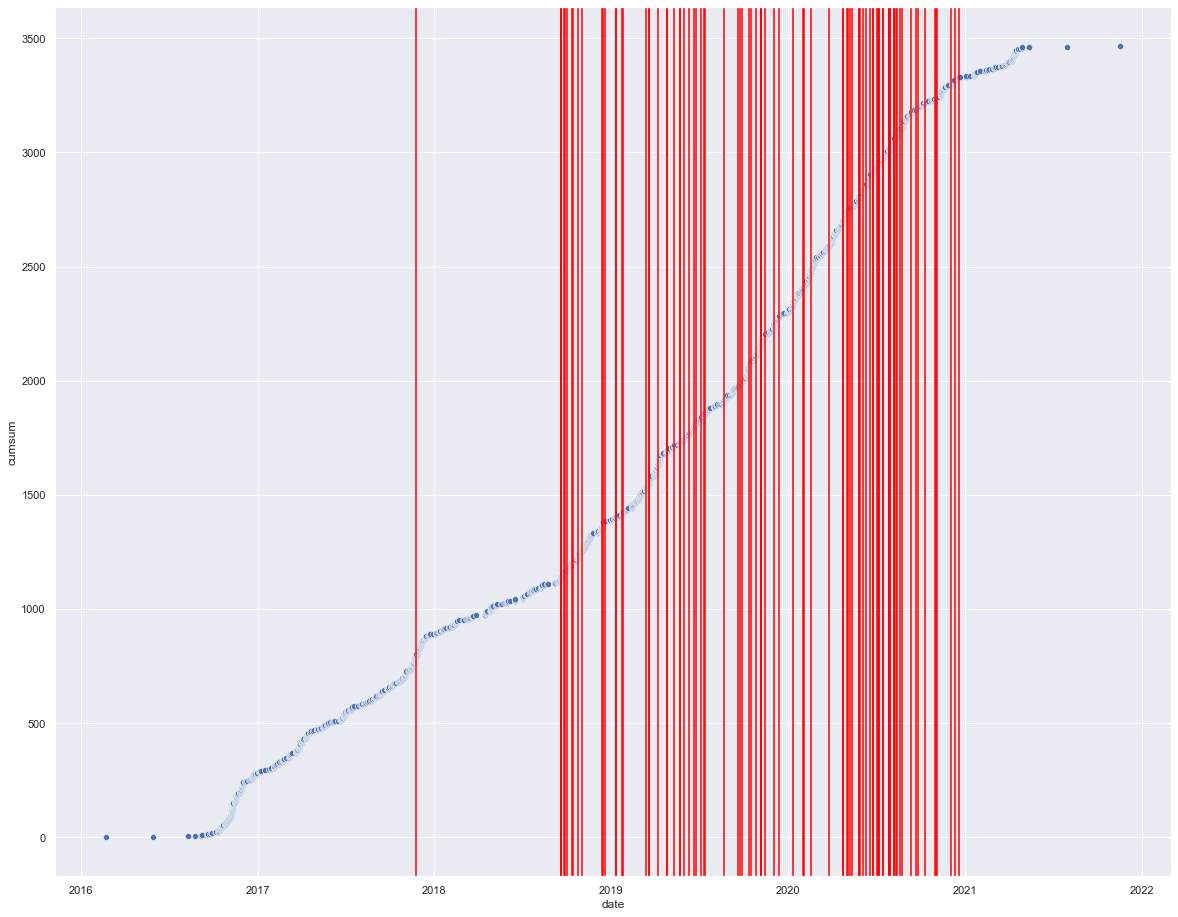

In [172]:
sns.set(rc={'figure.figsize':(20,16)})
for release in list(reldf['date']): plt.axvline(release,color="red")
sns.scatterplot(data=df, x="date",y="cumsum")

<AxesSubplot:xlabel='date', ylabel='dummy'>

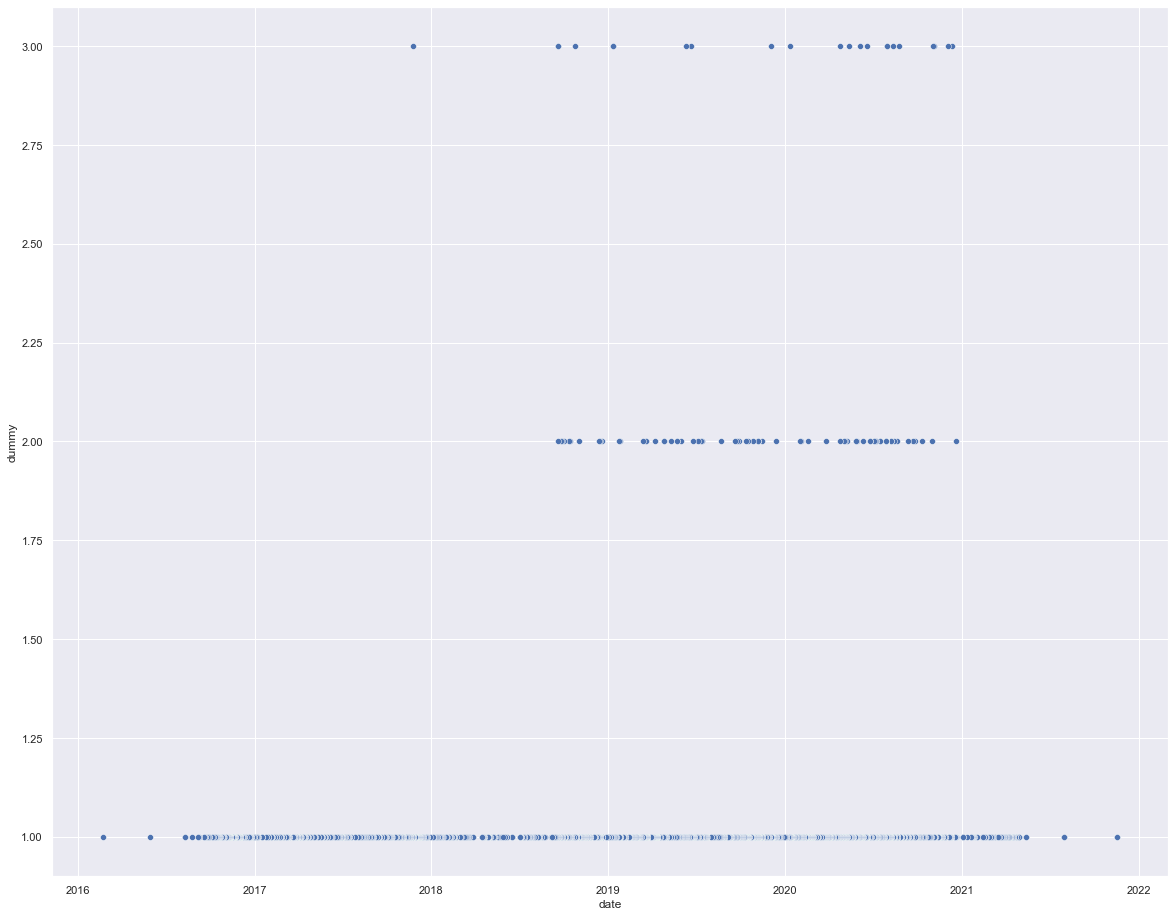

In [155]:
sns.set(rc={'figure.figsize':(20,16)})
sns.scatterplot(data=pd.concat([comdf,reldf])[['date','dummy']], x="date",y="dummy")

In [94]:
commits =  [g.get_commits("mozilla/DeepSpeech", {'page':x,'per_page':100}).json() for x in range(1,36)]

In [103]:
flatten(commits)[0]['commit']['author']

{'name': 'lissyx',
 'email': '1645737+lissyx@users.noreply.github.com',
 'date': '2021-11-17T17:52:52Z'}

In [107]:
pd.DataFrame([{'name':commit['commit']['author']['name'],'date':commit['commit']['author']['date'], 'html_url':commit['html_url'], 'message': commit['commit']['message']} for commit in flatten(commits)]).to_json("Commits.json")

In [49]:
#[i['url'] for i in e.json()] + 
[i['assets'] for i in page2.json()]

[[{'url': 'https://api.github.com/repos/mozilla/DeepSpeech/releases/assets/8849615',
   'id': 8849615,
   'node_id': 'MDEyOlJlbGVhc2VBc3NldDg4NDk2MTU=',
   'name': 'deepspeech-0.2.1-alpha.0.tgz',
   'label': '',
   'uploader': {'login': 'deepspeech-automation',
    'id': 43374812,
    'node_id': 'MDQ6VXNlcjQzMzc0ODEy',
    'avatar_url': 'https://avatars.githubusercontent.com/u/43374812?v=4',
    'gravatar_id': '',
    'url': 'https://api.github.com/users/deepspeech-automation',
    'html_url': 'https://github.com/deepspeech-automation',
    'followers_url': 'https://api.github.com/users/deepspeech-automation/followers',
    'following_url': 'https://api.github.com/users/deepspeech-automation/following{/other_user}',
    'gists_url': 'https://api.github.com/users/deepspeech-automation/gists{/gist_id}',
    'starred_url': 'https://api.github.com/users/deepspeech-automation/starred{/owner}{/repo}',
    'subscriptions_url': 'https://api.github.com/users/deepspeech-automation/subscriptions'

In [98]:
flatten(commits)[0]

{'sha': 'aa1d28530d531d0d92289bf5f11a49fe516fdc86',
 'node_id': 'C_kwDOA5e0KNoAKGFhMWQyODUzMGQ1MzFkMGQ5MjI4OWJmNWYxMWE0OWZlNTE2ZmRjODY',
 'commit': {'author': {'name': 'lissyx',
   'email': '1645737+lissyx@users.noreply.github.com',
   'date': '2021-11-17T17:52:52Z'},
  'committer': {'name': 'GitHub',
   'email': 'noreply@github.com',
   'date': '2021-11-17T17:52:52Z'},
  'message': 'Merge pull request #3703 from danieltinazzi/master\n\nFix M-AILABS broken link',
  'tree': {'sha': '48d0cdaa6dd738ee806d50c2694a364be515c8a0',
   'url': 'https://api.github.com/repos/mozilla/DeepSpeech/git/trees/48d0cdaa6dd738ee806d50c2694a364be515c8a0'},
  'url': 'https://api.github.com/repos/mozilla/DeepSpeech/git/commits/aa1d28530d531d0d92289bf5f11a49fe516fdc86',
  'comment_count': 0,
  'verification': {'verified': True,
   'reason': 'valid',
   'signature': '-----BEGIN PGP SIGNATURE-----\n\nwsBcBAABCAAQBQJhlUF0CRBK7hj4Ov3rIwAAkaoIAAQPGx3X/gKvMQHEnRZE0zA2\n7OPztiGl0xn/kThCRzhjSs/tRIuPik/Lv/H/dOb0HkxO8dI